This notebook compares the gnubg bearoff database to our calculations. It assumes that you have generated the data files with these commands

`./compute.py 15 6`

`./gnubg_to_store.py ~/gnubg/gnubg-1.06.002/`

For the latter, it should be a directory where you have the source of gnubg downloaded and made


In order to get reasonable precision, I had to hack the output of `gnubg/bearoffdump`. In particular, in the function `BearoffDumpOneSided`, I changed these lines

            sprintf(sz = sz + strlen(sz),
                    "%5u\t%7.3f\t%7.3f" "\t\t", i, aarProb[0][i] * 100.0f, aarProb[1][i] * 100.0f);

            if (pbc->fGammon)
                sprintf(sz = sz + strlen(sz),
                        "%7.3f\t%7.3f\n", aarGammonProb[0][i] * 100.0f, aarGammonProb[1][i] * 100.0f);

to

            sprintf(sz = sz + strlen(sz),
                    "%5u\t%17.13f\t%17.13f" "\t\t", i, aarProb[0][i] * 100.0f, aarProb[1][i] * 100.0f);

            if (pbc->fGammon)
                sprintf(sz = sz + strlen(sz),
                        "%17.13f\t%17.13f\n", aarGammonProb[0][i] * 100.0f, aarGammonProb[1][i] * 100.0f);


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import board
import gnubg_interface
import strategy

# Load the data

In [3]:
!ls -l data/

total 53032
-rw-rw-r-- 1 pfr pfr 27284736 May 28 22:16 bgend_store_15_6.hdf5
-rw-rw-r-- 1 pfr pfr    37712 Mar 24 19:17 bgend_store_6_3.hdf5
-rw-rw-r-- 1 pfr pfr    91920 Apr  5 13:24 bgend_store_6_4.hdf5
-rw-rw-r-- 1 pfr pfr   399688 Apr  5 13:26 bgend_store_6_6.hdf5
-rw-rw-r-- 1 pfr pfr  1352544 May 28 21:56 bgend_store_8_6.hdf5
-rw-rw-r-- 1 pfr pfr 24134504 May 17 14:25 gnubg_store_15_6.hdf5
-rw-rw-r-- 1 pfr pfr   246556 May 28 21:28 profile
-rw-rw-r-- 1 pfr pfr   244909 May 28 21:44 profile2
-rw-rw-r-- 1 pfr pfr   244909 May 28 21:52 profile3
-rw-rw-r-- 1 pfr pfr   244792 May 28 21:54 profile4


In [4]:
%%time
our_store = strategy.DistributionStore.load_hdf5('data/bgend_store_15_6.hdf5')
their_store = strategy.DistributionStore.load_hdf5('data/gnubg_store_15_6.hdf5')

CPU times: user 22.6 s, sys: 542 ms, total: 23.2 s
Wall time: 31.3 s


In [5]:
config = our_store.config

In [6]:
print(len(our_store.distribution_map))
print(len(their_store.distribution_map))
assert(len(our_store.distribution_map) == len(their_store.distribution_map))

54264
54264


# Examine the expected values

Our first verification will be that the expected values of the distributions are similar. Because of numeric noise and possible trimming the disitributions, we may not have exact equality.

In [7]:
board_ids = []
our_expected_vals = []
their_expected_vals = []
for board_id in our_store.distribution_map:
    ours = our_store.distribution_map[board_id]
    theirs = their_store.distribution_map[board_id]
    
    board_ids.append(board_id)
    our_expected_vals.append(ours.expected_value())
    their_expected_vals.append(theirs.expected_value())

our_expected_vals = np.array(our_expected_vals)
their_expected_vals = np.array(their_expected_vals)
diff_expected_vals = our_expected_vals - their_expected_vals

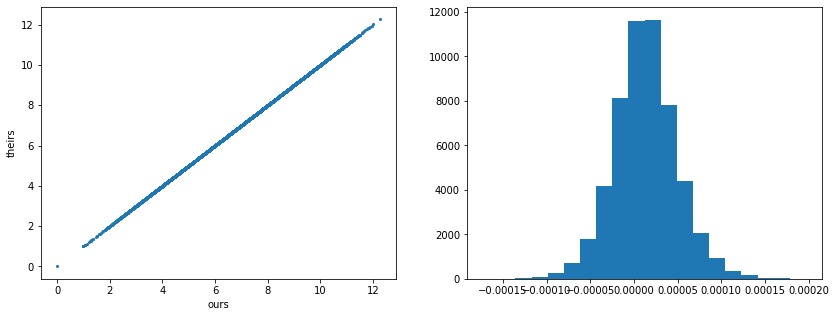

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(our_expected_vals, their_expected_vals, s=4)
axes[0].set_xlabel('ours')
axes[0].set_ylabel('theirs')

axes[1].hist(diff_expected_vals, bins=20)

pass

In [9]:
quantiles = [0, 0.001, 0.01, .99, .999, 1]
pd.DataFrame.from_dict({'quantile': quantiles, 
                        'value': np.quantile(diff_expected_vals, quantiles)})

,quantile,value
0,0.000,-0.000173
1,0.001,-0.000118
2,0.010,-0.000075
3,0.990,0.000105
4,0.999,0.000149
5,1.000,0.000197


# Examine predicted moves

The thing that matters in the end is whether we predict the same moves, even if the values of board are off slightly. This goes through and checks the best move by each database

In [26]:
%%time
move_disagreements = []
disagreements_boards_examined = 0
progress_indicator = strategy.ProgressIndicator(config.num_valid_boards, 500)

for board_id in our_store.distribution_map:
    progress_indicator.complete_one()
    if np.random.randint(0, 200) > 0:
        continue
    
    disagreements_boards_examined += 1
    
    b = board.Board.from_id(config, board_id)
    our_mcd = our_store.distribution_map[board_id]
    their_mcd = their_store.distribution_map[board_id]
    
    for roll in board.ROLLS:
        our_moves = our_store.compute_best_moves_for_roll(b, roll)
        their_moves = their_store.compute_best_moves_for_roll(b, roll)
        our_board = b.apply_moves(our_moves)
        their_board = b.apply_moves(their_moves)
        if our_board.get_id() == their_board.get_id():
            continue
        our_moves_our_ev = our_store.distribution_map[our_board.get_id()].expected_value()
        our_moves_their_ev = their_store.distribution_map[our_board.get_id()].expected_value()
        their_moves_our_ev = our_store.distribution_map[their_board.get_id()].expected_value()
        their_moves_their_ev = their_store.distribution_map[their_board.get_id()].expected_value()
        # We got to different boards, let's check that one or the other doesn't think they are equivalent
        move_disagreements.append( (b.get_id(), 
                                    roll.dice[0], roll.dice[1], 
                                    board.encode_moves_string(our_moves),
                                    our_moves_our_ev,
                                    our_moves_their_ev,
                                    board.encode_moves_string(their_moves),
                                    their_moves_our_ev,
                                    their_moves_their_ev,
                                   )
                                 )

500/54264 0.9%, 0.036322s elapsed, 3.941915s estimated total
1000/54264 1.8%, 0.038419s elapsed, 2.084743s estimated total
1500/54264 2.8%, 0.059707s elapsed, 2.159958s estimated total
2000/54264 3.7%, 0.136934s elapsed, 3.715294s estimated total
2500/54264 4.6%, 0.139112s elapsed, 3.019515s estimated total
3000/54264 5.5%, 0.177924s elapsed, 3.218296s estimated total
3500/54264 6.4%, 0.256728s elapsed, 3.980314s estimated total
4000/54264 7.4%, 0.275161s elapsed, 3.732835s estimated total
4500/54264 8.3%, 0.335934s elapsed, 4.050915s estimated total
5000/54264 9.2%, 0.427961s elapsed, 4.644579s estimated total
5500/54264 10.1%, 0.582652s elapsed, 5.748554s estimated total
6000/54264 11.1%, 0.585141s elapsed, 5.292013s estimated total
6500/54264 12.0%, 0.587410s elapsed, 4.903879s estimated total
7000/54264 12.9%, 0.644135s elapsed, 4.993338s estimated total
7500/54264 13.8%, 0.725564s elapsed, 5.249604s estimated total
8000/54264 14.7%, 0.812599s elapsed, 5.511862s estimated total
850

In [29]:
print(disagreements_boards_examined)
print(len(move_disagreements))
#print(move_disagreements)
for board_id, roll0, roll1, our_moves_str, our_moves_our_ev, our_moves_their_eve, their_moves_str, their_moves_our_ev, their_moves_their_ev in move_disagreements:
    print("\n=================\n{} roll=[{}, {}]".format(board_id, roll0, roll1))
    print("our_moves_our_ev: {}".format(our_moves_our_ev))
    print("our_moves_their_ev: {}".format(our_moves_their_ev))
    print("their_moves_our_ev: {}".format(their_moves_our_ev))
    print("their_moves_their_ev: {}".format(their_moves_their_ev))   
    
    b = board.Board.from_id(config, board_id)
    our_moves = board.decode_moves_string(our_moves_str)
    their_moves = board.decode_moves_string(their_moves_str)
    
    our_next = b.apply_moves(our_moves)
    print("Our moves: next ID {}, expected value ours={} theirs={}".format(
        our_next.get_id(), 
        our_store.distribution_map[our_next.get_id()].expected_value(),
        their_store.distribution_map[our_next.get_id()].expected_value()))
    print(b.pretty_string(our_moves))
    
    their_next = b.apply_moves(their_moves)
    print("Their moves: next ID {}, expected value ours={} theirs={}".format(
        their_next.get_id(), 
        our_store.distribution_map[their_next.get_id()].expected_value(),
        their_store.distribution_map[their_next.get_id()].expected_value()))
    print(b.pretty_string(their_moves))

237
1

1343477 roll=[3, 6]
our_moves_our_ev: 6.324489243101309
our_moves_their_ev: 6.32448335351422
their_moves_our_ev: 6.324491603624726
their_moves_their_ev: 6.32448335351422
Our moves: next ID 131051, expected value ours=6.324489243101309 theirs=6.32448335351422
0 1 o             x 
1 1 o             | 
2 11 ooooooooooo x | 
3 0             | | 
4 0             | | 
5 1 o           3 | 
6 1 o             6 

Their moves: next ID 196587, expected value ours=6.324491603624726 theirs=6.32448335351422
0 1 o             + 
1 1 o             | 
2 11 ooooooooooo   | 
3 0             x | 
4 0             | | 
5 1 o           | 6 
6 1 o           3   



Output from one sampled run:
```
[(<board.Board object at 0x7f2e65bc59e8>, Roll(dice=[1, 3], prob=0.05555555555555555), [Move(spot=5, count=1), Move(spot=3, count=3)], [Move(spot=2, count=1), Move(spot=3, count=3)]), (<board.Board object at 0x7f2e65bcafd0>, Roll(dice=[1, 1, 1, 1], prob=0.027777777777777776), [Move(spot=6, count=1), Move(spot=3, count=1), Move(spot=2, count=1), Move(spot=1, count=1)], [Move(spot=6, count=1), Move(spot=6, count=1), Move(spot=6, count=1), Move(spot=5, count=1)])]
'''

# Examine the probabilities

In [11]:
# The 1e-4 threshold is because of the limited precision from going through the text parsing from gnubg
total_boards = 0
total_correct = 0
for board_id in our_store.distribution_map:
    total_boards += 1
    ours_orig = our_store.distribution_map[board_id]
    ours = ours_orig.trim_low_prob(1e-5)
    theirs = their_store.distribution_map[board_id]
    if len(ours) != len(theirs):
        print('Board ID {}, Position ID {}, different lengths\nours(orig): {}\nours(trim): {}\ntheirs  : {}'
              .format(board_id, gnubg_interface.board_id_to_gnubg_id_str(our_store.config, board_id), ours_orig, ours, theirs))
        continue

    if not np.allclose(ours.dist, theirs.dist, atol=1e-4):
        print('Board ID {}, Position ID {}, mismatch\nours(orig): {}\nours(trim): {}\ntheirs  : {}'
              .format(board_id, gnubg_interface.board_id_to_gnubg_id_str(our_store.config, board_id), ours_orig, ours, theirs))
        continue
        
    total_correct += 1
    
print('{}/{} correct ({:.2f}%)'.format(total_correct, total_boards, total_correct / total_boards))

Board ID 1001343, Position ID Rw8AAAAAAAAAAA, different lengths
ours(orig): MCD(4.768467, [0.         0.         0.00462963 0.07664609 0.21493306 0.55560477
 0.14573638 0.00244216 0.         0.        ])
ours(trim): MCD(4.768467, [0.         0.         0.00462963 0.07664609 0.21493306 0.55560477
 0.14573638 0.00244216])
theirs  : MCD(4.768566, [0.00000000e+00 0.00000000e+00 4.62348402e-03 7.66460657e-02
 2.14938583e-01 5.55596237e-01 1.45738916e-01 2.44144350e-03
 1.52590219e-05])
Board ID 1002239, Position ID pQcAAAAAAAAAAA, different lengths
ours(orig): MCD(4.400611, [0.         0.         0.00771605 0.14351852 0.34618627 0.44682389
 0.05447291 0.00127447 0.         0.        ])
ours(trim): MCD(4.400611, [0.         0.         0.00771605 0.14351852 0.34618627 0.44682389
 0.05447291 0.00127447])
theirs  : MCD(4.400687, [0.00000000e+00 0.00000000e+00 7.72106528e-03 1.43526363e-01
 3.46181412e-01 4.46799431e-01 5.44747066e-02 1.28175780e-03
 1.52590219e-05])
Board ID 1003514, Position I

 1.52590219e-05])
Board ID 1035710, Position ID 3+YHAAAAAAAAAA, different lengths
ours(orig): MCD(7.984562, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.07167353e-04 9.03483627e-03 8.14848403e-02 2.17985651e-01
 3.52185288e-01 2.86991177e-01 5.04700012e-02 1.73163526e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(7.984562, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.07167353e-04 9.03483627e-03 8.14848403e-02 2.17985651e-01
 3.52185288e-01 2.86991177e-01 5.04700012e-02 1.73163526e-03])
theirs  : MCD(7.984741, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.06813153e-04 9.03334081e-03 8.14831734e-02 2.17990379e-01
 3.52162971e-01 2.86991692e-01 5.04768467e-02 1.73952848e-03
 1.52590219e-05])
Board ID 1035735, Position ID 3fwAAAAAAAAAAA, different lengths
ours(orig): MCD(6.836483, [0.         0.         0.         0.00042867 0.01483672 0.08469456
 0.23454495 0.40249572 0.23992328 0.02241562 0.000651

 3.80117493e-01 5.33195953e-01 3.14946222e-02 1.52590219e-05])
Board ID 1170367, Position ID tyMAAAAAAAAAAA, different lengths
ours(orig): MCD(4.543432, [0.         0.         0.         0.04858968 0.37308111 0.56458657
 0.01373431 0.         0.        ])
ours(trim): MCD(4.543432, [0.         0.         0.         0.04858968 0.37308111 0.56458657
 0.01373431])
theirs  : MCD(4.543511, [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.85847235e-02
 3.73083076e-01 5.64583855e-01 1.37331200e-02 1.52590219e-05])
Board ID 1170815, Position ID 3REAAAAAAAAAAA, different lengths
ours(orig): MCD(4.290618, [0.         0.         0.00385802 0.12806499 0.45132637 0.40704831
 0.00969333 0.         0.        ])
ours(trim): MCD(4.290618, [0.         0.         0.00385802 0.12806499 0.45132637 0.40704831
 0.00969333])
theirs  : MCD(4.290684, [0.00000000e+00 0.00000000e+00 3.86053264e-03 1.28068972e-01
 4.51316071e-01 4.07049637e-01 9.68947887e-03 1.52590219e-05])
Board ID 1173375, Position ID 5xEAAAAAAAA

 2.97550917e-03 1.52590219e-05])
Board ID 1375863, Position ID 508BAAAAAAAAAA, different lengths
ours(orig): MCD(6.463463, [0.         0.         0.         0.00042867 0.01860485 0.12968048
 0.35104922 0.37305037 0.12288849 0.00428877 0.         0.
 0.        ])
ours(trim): MCD(6.463463, [0.         0.         0.         0.00042867 0.01860485 0.12968048
 0.35104922 0.37305037 0.12288849 0.00428877])
theirs  : MCD(6.463569, [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.27252613e-04
 1.86007476e-02 1.29686432e-01 3.51049080e-01 3.73052559e-01
 1.22880907e-01 4.28778499e-03 1.52590219e-05])
Board ID 1375982, Position ID d38KAAAAAAAAAA, different lengths
ours(orig): MCD(7.383156, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.69109130e-04 1.58507130e-02 1.36902726e-01 3.86062441e-01
 3.71603278e-01 8.68749498e-02 2.42715904e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(7.383156, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000

 3.03959727e-02 7.78210089e-04 1.52590219e-05])
Board ID 1498783, Position ID elsAAAAAAAAAAA, different lengths
ours(orig): MCD(5.790002, [0.         0.         0.         0.00838049 0.06986776 0.27969716
 0.42672357 0.1966409  0.01804878 0.00063178 0.         0.
 0.         0.        ])
ours(trim): MCD(5.790002, [0.         0.         0.         0.00838049 0.06986776 0.27969716
 0.42672357 0.1966409  0.01804878 0.00063178])
theirs  : MCD(5.790112, [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.37720275e-03
 6.98710585e-02 2.79697857e-01 4.26718521e-01 1.96643009e-01
 1.80514228e-02 6.25619888e-04 1.52590219e-05])
Board ID 1498799, Position ID 9bYAAAAAAAAAAA, mismatch
ours(orig): MCD(6.010304, [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.21639232e-04
 4.14999619e-02 2.44685425e-01 4.06693150e-01 2.72900742e-01
 3.20638398e-02 1.21330868e-03 2.17709774e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(6.010304, [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.216392

 1.52590219e-05])
Board ID 1547871, Position ID eV4AAAAAAAAAAA, mismatch
ours(orig): MCD(6.117441, [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.14471879e-03
 4.60938691e-02 2.14476206e-01 3.46873201e-01 3.22643027e-01
 5.94384039e-02 2.30137346e-03 2.90102201e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(6.117441, [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.14471879e-03
 4.60938691e-02 2.14476206e-01 3.46873201e-01 3.22643027e-01
 5.94384039e-02 2.30137346e-03 2.90102201e-05])
theirs  : MCD(6.117433, [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.14831793e-03
 4.60822487e-02 2.14312954e-01 3.47173271e-01 3.22575722e-01
 5.93728542e-02 2.30411232e-03 3.05180438e-05])
Board ID 1547966, Position ID X88LAAAAAAAAAA, different lengths
ours(orig): MCD(7.867889, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.30409808e-04 1.24917441e-02 8.67198332e-02 2.46400255e-01
 3.67700470e-01 2.48124476e-01 3.69127999e-02 1.41231803e-03
 0.00000000e+00 0.0000

Board ID 1636207, Position ID u8cAAAAAAAAAAA, different lengths
ours(orig): MCD(5.832091, [0.         0.         0.         0.00107167 0.04445778 0.27862926
 0.47618409 0.19638376 0.00326341 0.         0.         0.        ])
ours(trim): MCD(5.832091, [0.         0.         0.         0.00107167 0.04445778 0.27862926
 0.47618409 0.19638376 0.00326341])
theirs  : MCD(5.832197, [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.06813155e-03
 4.44647884e-02 2.78629742e-01 4.76173058e-01 1.96383610e-01
 3.26543063e-03 1.52590219e-05])
Board ID 1636342, Position ID +3sMAAAAAAAAAA, different lengths
ours(orig): MCD(7.579659, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.96473480e-04 1.11275931e-02 1.11256868e-01 3.36511301e-01
 3.73379611e-01 1.62116195e-01 5.40319030e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(7.579659, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.96473480e-04 1.11275931e-02 1.11256868e-01 3.36511301e-

 1.52590219e-05])
Board ID 1764927, Position ID 3DUAAAAAAAAAAA, different lengths
ours(orig): MCD(5.638851, [0.         0.         0.         0.01161694 0.10374276 0.30344763
 0.412996   0.15227803 0.01531407 0.00059518 0.         0.
 0.         0.        ])
ours(trim): MCD(5.638851, [0.         0.         0.         0.01161694 0.10374276 0.30344763
 0.412996   0.15227803 0.01531407 0.00059518])
theirs  : MCD(5.639002, [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.16121149e-02
 1.03746090e-01 3.03440895e-01 4.12985420e-01 1.52285042e-01
 1.53200579e-02 5.95101863e-04 1.52590219e-05])
Board ID 1765114, Position ID fXcNAAAAAAAAAA, different lengths
ours(orig): MCD(7.678880, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.10144223e-04 8.98695826e-03 9.17637187e-02 3.07812596e-01
 4.06762650e-01 1.71823539e-01 1.23297127e-02 4.02210255e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(7.678880, [0.00000000e+0

 1.52590219e-05])
Board ID 1810015, Position ID eW4AAAAAAAAAAA, mismatch
ours(orig): MCD(6.122096, [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.61556927e-03
 4.29729176e-02 2.11155043e-01 3.63679185e-01 3.19571965e-01
 5.45875195e-02 2.37016285e-03 4.71937299e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(6.122096, [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.61556927e-03
 4.29729176e-02 2.11155043e-01 3.63679185e-01 3.19571965e-01
 5.45875195e-02 2.37016285e-03 4.71937299e-05])
theirs  : MCD(6.122072, [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.61532021e-03
 4.29541492e-02 2.10971241e-01 3.64034462e-01 3.19508667e-01
 5.45052242e-02 2.36514837e-03 4.57770657e-05])
Board ID 1810046, Position ID P88NAAAAAAAAAA, different lengths
ours(orig): MCD(8.000178, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.50034294e-04 8.52382330e-03 6.50514793e-02 2.20419339e-01
 3.80168798e-01 2.76159202e-01 4.77733225e-02 1.74530344e-03
 0.0000

 3.20439450e-04 1.52590219e-05])
Board ID 1832615, Position ID ar8BAAAAAAAAAA, different lengths
ours(orig): MCD(7.698323, [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.92901235e-04
 5.30478395e-03 3.36189112e-02 1.32205000e-01 2.38624106e-01
 3.28480053e-01 2.04958431e-01 5.06219174e-02 5.66516205e-03
 3.19137122e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(7.698323, [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.92901235e-04
 5.30478395e-03 3.36189112e-02 1.32205000e-01 2.38624106e-01
 3.28480053e-01 2.04958431e-01 5.06219174e-02 5.66516205e-03
 3.19137122e-04])
theirs  : MCD(7.698421, [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.98367275e-04
 5.31013966e-03 3.36156273e-02 1.32204161e-01 2.38620586e-01
 3.28480949e-01 2.04959183e-01 5.06141758e-02 5.66109717e-03
 3.20439450e-04 1.52590219e-05])
Board ID 1832727, Position ID cb8BAAAAAAAAAA, different lengths
ours(orig): MCD(7.723635, [0.00000000e+

 1.52590219e-05])
Board ID 192479, Position ID vwsAAAAAAAAAAA, different lengths
ours(orig): MCD(4.438411, [0.         0.         0.         0.06342164 0.4347065  0.50186392
 0.        ])
ours(trim): MCD(4.438411, [0.         0.         0.         0.06342164 0.4347065  0.50186392])
theirs  : MCD(4.438437, [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.34317541e-02
 4.34714279e-01 5.01838684e-01 1.52590219e-05])
Board ID 1924854, Position ID e68OAAAAAAAAAA, different lengths
ours(orig): MCD(7.803847, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.47057423e-04 7.78206976e-03 7.57086523e-02 2.76184772e-01
 4.05548039e-01 2.14321663e-01 1.97660865e-02 5.33007705e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(7.803847, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.47057423e-04 7.78206976e-03 7.57086523e-02 2.76184772e-01
 4.05548039e-01 2.14321663e-01 1.97660865e-02 5.33007705e-04])
theirs

 3.05180438e-04 1.52590219e-05])
Board ID 1956782, Position ID 1+0OAAAAAAAAAA, different lengths
ours(orig): MCD(8.102128, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.38263984e-05 4.81565098e-03 5.33417894e-02 2.13054046e-01
 3.68265790e-01 2.90720651e-01 6.35094703e-02 5.89242651e-03
 3.16801742e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(8.102128, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.38263984e-05 4.81565098e-03 5.33417894e-02 2.13054046e-01
 3.68265790e-01 2.90720651e-01 6.35094703e-02 5.89242651e-03
 3.16801742e-04])
theirs  : MCD(8.102236, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.62951095e-05 4.82185096e-03 5.33455372e-02 2.13061714e-01
 3.68246002e-01 2.90714893e-01 6.35080481e-02 5.88998258e-03
 3.20439450e-04 1.52590219e-05])
Board ID 1956789, Position ID 7XYHAAAAAAAAAA, different lengths
ours(orig): MCD(7.830032, [0.00000000e+

 1.52590219e-05])
Board ID 1995765, Position ID /ZwHAAAAAAAAAA, different lengths
ours(orig): MCD(7.874434, [0.         0.         0.         0.         0.00125445 0.01225106
 0.07187448 0.2474599  0.38665199 0.25408247 0.02584859 0.00056824
 0.         0.         0.         0.         0.         0.        ])
ours(trim): MCD(7.874434, [0.         0.         0.         0.         0.00125445 0.01225106
 0.07187448 0.2474599  0.38665199 0.25408247 0.02584859 0.00056824])
theirs  : MCD(7.874571, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.25123978e-03 1.22529948e-02 7.18699932e-02 2.47455559e-01
 3.86663628e-01 2.54077969e-01 2.58487844e-02 5.64583801e-04
 1.52590219e-05])
Board ID 1996254, Position ID 7zoPAAAAAAAAAA, different lengths
ours(orig): MCD(8.067654, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.44675926e-04 6.22562935e-03 5.38683294e-02 1.99353795e-01
 3.90018821e-01 3.07311971e-01 4.24512909e-02 6.17246782e-04
 0.00000000e+00 0.00000000e+0

 4.27252613e-04 1.52590219e-05])
Board ID 2025389, Position ID 67kHAAAAAAAAAA, different lengths
ours(orig): MCD(8.104423, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.37073236e-04 9.89874074e-03 5.86915126e-02 2.03480386e-01
 3.52338993e-01 2.98566261e-01 6.97099352e-02 6.24953889e-03
 3.18068731e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(8.104423, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.37073236e-04 9.89874074e-03 5.86915126e-02 2.03480386e-01
 3.52338993e-01 2.98566261e-01 6.97099352e-02 6.24953889e-03
 3.18068731e-04])
theirs  : MCD(8.104631, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.32433051e-04 9.90310490e-03 5.86861992e-02 2.03463783e-01
 3.52346077e-01 2.98573284e-01 6.97032118e-02 6.25619888e-03
 3.20439450e-04 1.52590219e-05])
Board ID 2025395, Position ID 9twDAAAAAAAAAA, different lengths
ours(orig): MCD(7.952873, [0.00000000e+

 4.27252613e-04 1.52590219e-05])
Board ID 2051961, Position ID 3tMHAAAAAAAAAA, different lengths
ours(orig): MCD(8.372472, [0.         0.         0.         0.         0.00049476 0.00736099
 0.04521656 0.15216854 0.31448799 0.33510326 0.13179903 0.01292175
 0.00043717 0.         0.         0.         0.         0.
 0.         0.        ])
ours(trim): MCD(8.372472, [0.         0.         0.         0.         0.00049476 0.00736099
 0.04521656 0.15216854 0.31448799 0.33510326 0.13179903 0.01292175
 0.00043717])
theirs  : MCD(8.372732, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.88288701e-04 7.35484838e-03 4.52124834e-02 1.52162971e-01
 3.14488449e-01 3.35103378e-01 1.31807432e-01 1.29243922e-02
 4.42511626e-04 1.52590219e-05])
Board ID 2052014, Position ID 16cPAAAAAAAAAA, different lengths
ours(orig): MCD(8.535753, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.01327923e-05 3.83844350e-03 3.41740062e-02 1.19398654e-01
 2.96592749e-01 3.71172386e-01 1.

 3.05180438e-04 1.52590219e-05])
Board ID 2072123, Position ID x/MDAAAAAAAAAA, different lengths
ours(orig): MCD(8.329643, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.37073236e-04 1.04914192e-02 4.93400545e-02 1.57700589e-01
 3.04356795e-01 3.44891132e-01 1.22121776e-01 1.00189132e-02
 3.32727893e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(8.329643, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.37073236e-04 1.04914192e-02 4.93400545e-02 1.57700589e-01
 3.04356795e-01 3.44891132e-01 1.22121776e-01 1.00189132e-02
 3.32727893e-04])
theirs  : MCD(8.329824, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.32433051e-04 1.04982066e-02 4.93324184e-02 1.57701988e-01
 3.04356461e-01 3.44884415e-01 1.22117949e-01 1.00251770e-02
 3.35698500e-04 1.52590219e-05])
Board ID 2072151, Position ID 5fkBAAAAAAAAAA, different lengths
ours(orig): MCD(7.917409, [0.00000000e+

Board ID 2092760, Position ID bPcPAAAAAAAAAA, mismatch
ours(orig): MCD(10.329059, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.07167353e-05 4.84584969e-04 4.72101176e-03 2.45444153e-02
 7.69626455e-02 1.71528511e-01 2.58611416e-01 2.51621093e-01
 1.49183068e-01 5.10684257e-02 1.00232586e-02 1.15652144e-03
 8.07523813e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00])
ours(trim): MCD(10.329059, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.07167353e-05 4.84584969e-04 4.72101176e-03 2.45444153e-02
 7.69626455e-02 1.71528511e-01 2.58611416e-01 2.51621093e-01
 1.49183068e-01 5.10684257e-02 1.00232586e-02 1.15652144e-03
 8.07523813e-05])
theirs  : MCD(10.329091, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.52590219e-05 4.88288701e-04 4.73029673e-03 2.45975447e-02
 7.69817686e-02 1.71419868e-01 2.58442039e-01 2.51804390e-01
 1.4921

 1.13221943e-02 1.52590219e-05])
Board ID 638462, Position ID /94EAAAAAAAAAA, different lengths
ours(orig): MCD(6.990308, [0.         0.         0.         0.         0.00072874 0.03332149
 0.22376328 0.45920973 0.28296724 0.         0.        ])
ours(trim): MCD(6.990308, [0.         0.         0.         0.         0.00072874 0.03332149
 0.22376328 0.45920973 0.28296724])
theirs  : MCD(6.990372, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.32433051e-04 3.33257008e-02 2.23773556e-01 4.59189758e-01
 2.82963314e-01 1.52590219e-05])
Board ID 645055, Position ID rxMAAAAAAAAAAA, different lengths
ours(orig): MCD(4.524418, [0.         0.         0.         0.0573774  0.38969562 0.52400512
 0.02891298 0.        ])
ours(trim): MCD(4.524418, [0.         0.         0.         0.0573774  0.38969562 0.52400512
 0.02891298])
theirs  : MCD(4.524498, [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.73739243e-02
 3.89700165e-01 5.23994789e-01 2.89158463e-02 1.52590219e-05])
Board ID 

 7.09697104e-02 1.61745638e-03 1.52590219e-05])
Board ID 784799, Position ID 5i8AAAAAAAAAAA, different lengths
ours(orig): MCD(5.956962, [0.         0.         0.         0.0096665  0.05900992 0.25379045
 0.35333947 0.29139629 0.03195197 0.0008382  0.         0.
 0.         0.        ])
ours(trim): MCD(5.956962, [0.         0.         0.         0.0096665  0.05900992 0.25379045
 0.35333947 0.29139629 0.03195197 0.0008382 ])
theirs  : MCD(5.957092, [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.65896070e-03
 5.90066385e-02 2.53788052e-01 3.53353157e-01 2.91386280e-01
 3.19523931e-02 8.39246213e-04 1.52590219e-05])
Board ID 784991, Position ID 6S8AAAAAAAAAAA, different lengths
ours(orig): MCD(5.910114, [0.         0.         0.         0.01391032 0.06661225 0.25310005
 0.36100467 0.27336611 0.03115093 0.00084836 0.         0.
 0.         0.        ])
ours(trim): MCD(5.910114, [0.         0.         0.         0.01391032 0.06661225 0.25310005
 0.36100467 0.27336611 0.03115093 0.00084836]

 1.52590219e-05])
Board ID 916894, Position ID z/4GAAAAAAAAAA, different lengths
ours(orig): MCD(7.824497, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.82184499e-04 1.05329135e-02 9.04519385e-02 2.80215755e-01
 3.32631035e-01 2.54710450e-01 3.05020308e-02 7.65373558e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00])
ours(trim): MCD(7.824497, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.82184499e-04 1.05329135e-02 9.04519385e-02 2.80215755e-01
 3.32631035e-01 2.54710450e-01 3.05020308e-02 7.65373558e-04])
theirs  : MCD(7.824613, [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.83108263e-04 1.05287242e-02 9.04554844e-02 2.80216656e-01
 3.32631416e-01 2.54703579e-01 3.05027843e-02 7.62951076e-04
 1.52590219e-05])
Board ID 917101, Position ID m38DAAAAAAAAAA, different lengths
ours(orig): MCD(7.731244, [0.         0.         0.         0.         0.00180101 0.02696218
 0.10429202 0.2740215  0.32458523 0.235

 2.62485676e-01 5.26741457e-02 2.01419085e-03 1.52590219e-05])
51568/54264 correct (0.95%)
